# spinal_test3.ipynb

This test is similar to `spinal_test2.ipynb`, but the plant will now be the pendulum or the planar arm.

## PART 1
### The pendulum as a plant

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
# Create the neuronal populations
#des_ang = 0.2 # "predicted" perceived angle in SP
des_angs = 0.05 + 0.95*np.random.random(2000) # list of "predicted" angles
#des_vel = 0.1 # "predicted" perceived angular velocity SP
des_vels = 0.05 + 0.95*np.random.random(2000) # list of "predicted" velocities
pres_interv = 20. # interval that desired values last
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz2 = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz2 = lambda : (1. + par_heter*(np.random.rand(2)-0.5))
randz4 = lambda : (1. + par_heter*(np.random.rand(4)-0.5))


# PARAMETER DICTIONARIES
net_params = {'min_delay' : 0.001,
              'min_buff_size' : 10 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0. * randz2(),
             'slope' : 1. * randz2(),
             'init_val' : 0.2 * randz2(),
             'tau' : 0.05 * randz2() }
SP_params = {'type' : unit_types.source,
             'init_val' : [des_angs[0], des_vels[0]],
             'function' : [lambda t: des_angs[int(round(t/pres_interv))],
                           lambda t: des_vels[int(round(t/pres_interv))]] }
SPF_params = {'type' : unit_types.out_norm_sig,
              'thresh' : 0.5 * randz4(),
              'slope' : 4. * randz4(),
              'delay' : 0.32,
              'init_val' : 0.3 * randz4(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.05 * randz4(),
              'des_out_w_abs_sum' : 1. }
init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
M_params = {'type' : unit_types.am_pm_oscillator,
            'integ_meth' : 'odeint',
            'tau_u' : 0.1 * randz2(),
            'tau_c' : 0.2 * randz2(),
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : [r*init_base for r in np.random.random(2)],
            'multidim' : True,
            'omega' : 8.*np.pi,
            'F' : 'zero', #'input_sum',
            'tau_fast': 0.01,
            'tau_mid' : 0.05,
            'tau_slow' : 1.,
            'custom_inp_del' : 230,
            'delay' : 0.32,
            'mu' : 0.,
            'sigma' : 0.0 }
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }
# plant parameters
P_params = {'type' : plant_models.pendulum,
            'length' : 0.5,
            'mass' : 1.,
            'init_angle' : 0.,
            'init_ang_vel' : 0.,
            'g' : 0.,
            'inp_gain' : 2.,
            'mu' : 0.05,
            'tau' : 0.1 } # a made-up time constant for the plant 
                          # see create_freqs_steps below

# CONNECTION DICTIONARIES
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SPF__M_conn = {'rule': 'all_to_all',
               'delay': 0.02 }
SPF__M_syn = {'type' : synapse_types.rga,
              'lrate': 50.,
              'inp_ports': 0,
              'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
# motor units to plant
M0__P_conn = {'inp_ports' : 0,
             'delays': 0.01 }
M0__P_syn = {'type': synapse_types.static,
            'init_w' : 1.5 }
M1__P_conn = M0__P_conn
M1__P_syn = {'type': synapse_types.static,
             'init_w' : -1.5 }
# plant to sensory
P__SF_conn = {'port_map' : [[(0,0)], [(1,0)]],
              'delays' : 0.01 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
# lateral connections in M
M__M_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
M__M_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 1,
            'init_w' : -0.5 }
            
def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        Args:
            n : number of units
            w : base omega value (rad)
            r : amplitude of noise as fraction of original value
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays. 
    """
    ws = w * (1. + r*((np.random.random(n) - 0.5)))
    ws = ws / M_params['tau_t'] # angular frequencies
    mp_del = np.arctan(np.mean(P_params['tau'])*ws)/ws
    psf_del = np.arctan(np.mean(SF_params['tau'])*ws)/ws
    sfspf_del = np.arctan(np.mean(SPF_params['tau'])*ws)/ws
    D = [M1__P_conn['delays'], P__SF_conn['delays'],
         SFe__SPF_conn['delay'], SPF__M_conn['delay']]
    d1 = mp_del + psf_del + sfspf_del + sum(D)
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

# CREATING UNITS
net = network(net_params)
SF = net.create(2, SF_params)
SP = net.create(2, SP_params)
SPF = net.create(4, SPF_params)
P = net.create(1, P_params)
# creating M with heterogeneous frequencies
omegas, del_steps = create_freqs_steps(2, M_params['omega'], par_heter)
M_params['omega'] = omegas
M_params['custom_inp_del'] = del_steps
M = net.create(2, M_params)

SPF_M0_track = net.create(4, track_params) # to track synaptic weights at M[0]
spf_diff_track = net.create(4, track_params) # to track SPF derivatives used in M
M0_I0_track = net.create(1, track_params) # to track the 4th state variable of M (I0)
xp_track = net.create(1, track_params) # del_avg_inp_deriv of M1 at port 1
up_track = net.create(1, track_params) # to track the derivative of M1
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for M1 at port 1
spj_track = net.create(1, track_params) # input derivative for SPF1--M1
dc_track = net.create(2, track_params) # DC component of M units


# CONNECTING
net.connect(SF, SPF[0::2], SFe__SPF_conn, SFe__SPF_syn) # indices 0,2
net.connect(SP, SPF[0::2], SPi__SPF_conn, SPi__SPF_syn)
net.connect(SF, SPF[1::2], SFi__SPF_conn, SFi__SPF_syn) # indices 1,3
net.connect(SP, SPF[1::2], SPe__SPF_conn, SPe__SPF_syn)
net.connect(SPF, M, SPF__M_conn, SPF__M_syn)
net.set_plant_inputs([M[0]], P, M0__P_conn, M0__P_syn)
net.set_plant_inputs([M[1]], P, M1__P_conn, M1__P_syn)
net.set_plant_outputs(P, SF, P__SF_conn, P__SF_syn)
net.connect([M[0]], [M[1]], M__M_conn, M__M_syn)
net.connect([M[1]], [M[0]], M__M_conn, M__M_syn)

# SETTING UP WEIGHT TRACKING -- depends on the order of unit creation!!!!!!
# This is dependent on the order in which net.connect is called above
net.units[SPF_M0_track[0]].set_function(lambda t: net.syns[M[0]][0].w) # SPF0--M0
net.units[SPF_M0_track[1]].set_function(lambda t: net.syns[M[0]][1].w) # SPF1--M0
net.units[SPF_M0_track[2]].set_function(lambda t: net.syns[M[0]][2].w) # SPF2--M0
net.units[SPF_M0_track[3]].set_function(lambda t: net.syns[M[0]][3].w) # SPF3--M0

# SETTING UP DERIVATIVE TRACKING
net.units[spf_diff_track[0]].set_function(lambda t: net.units[M[0]].inp_deriv_mp[0][0]) # SPF0 diff
net.units[spf_diff_track[1]].set_function(lambda t: net.units[M[0]].inp_deriv_mp[0][1]) # SPF1 diff
net.units[spf_diff_track[2]].set_function(lambda t: net.units[M[0]].inp_deriv_mp[0][2]) # SPF2 diff
net.units[spf_diff_track[3]].set_function(lambda t: net.units[M[0]].inp_deriv_mp[0][3]) # SPF3 diff

# SETTING TRACKING OF PLASTICITY FACTORS FOR SPF0-->M0
net.units[xp_track[0]].set_function(lambda t: net.units[M[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[M[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[M[0]].get_lpf_fast(po_de) - 
                                    net.units[M[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[M[0]].avg_inp_deriv_mp[0])
ds = net.syns[M[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[SPF[0]].get_lpf_fast(ds) - 
                                     net.units[SPF[0]].get_lpf_mid(ds))

# SETTING UP TRACKING OF M STATE VARIABLES
net.units[dc_track[0]].set_function(lambda t: net.units[M[0]].buffer[1, -1])
net.units[dc_track[1]].set_function(lambda t: net.units[M[1]].buffer[1, -1])

net.units[M0_I0_track[0]].set_function(lambda t: net.units[M[0]].buffer[3][-1])

In [3]:
start_time = time.time()
times, data, plant_data  = net.run(5.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 7.5869669914245605 seconds


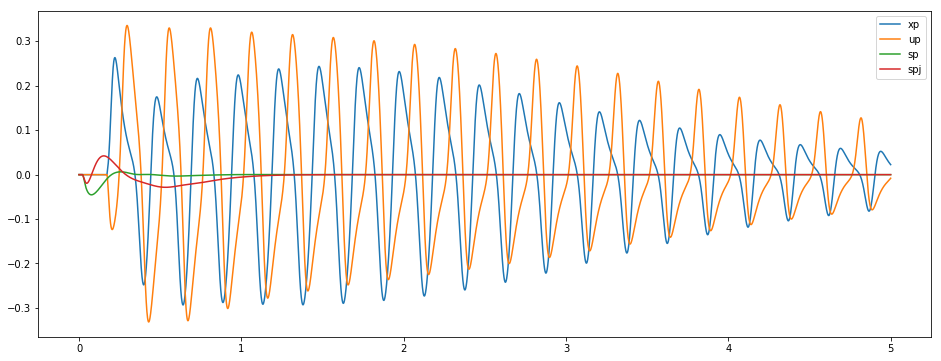

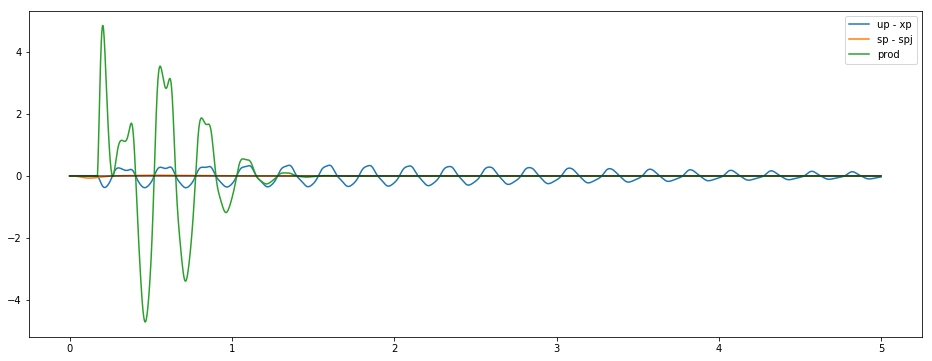

In [4]:
# plot all factors in the SPF0--M0 synaptic plasticity
fs = (16,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

[0.11012411 0.14495036 0.01849129 0.51328764]
0.010872652302113416
0.9760610558739008


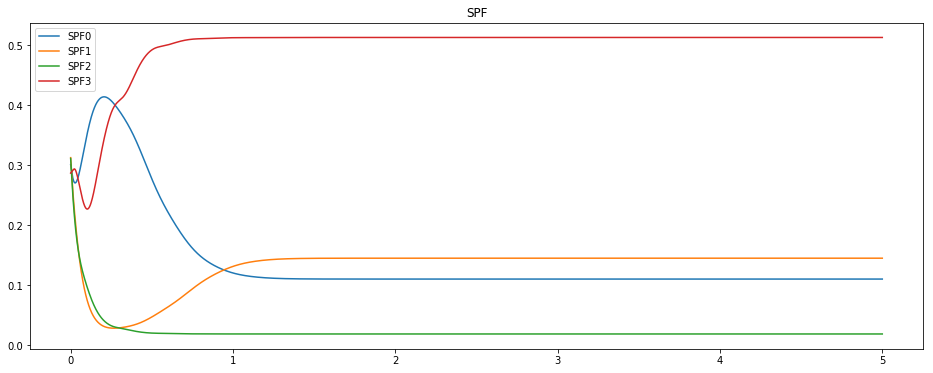

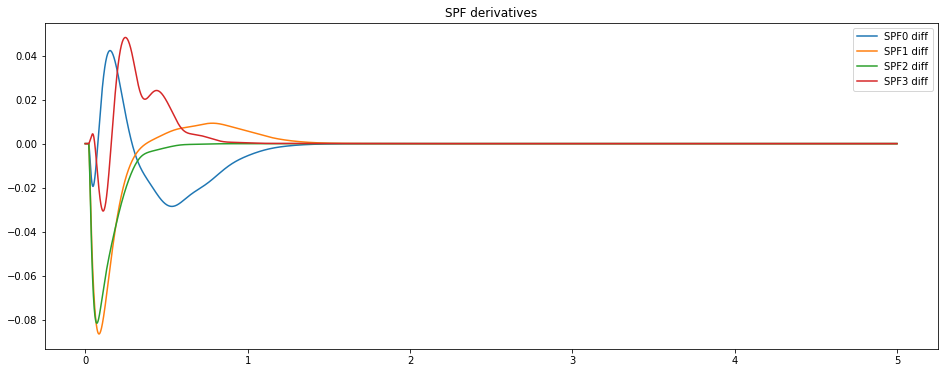

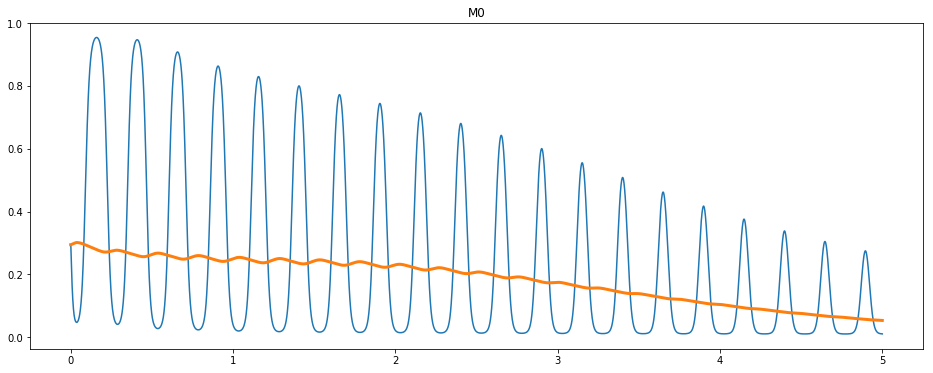

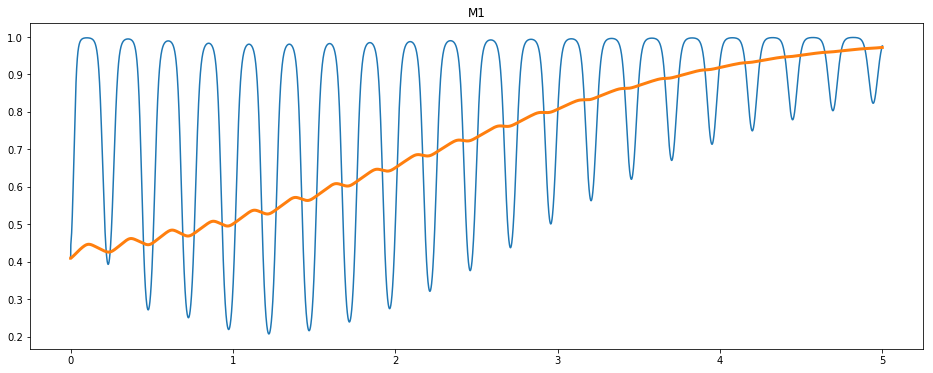

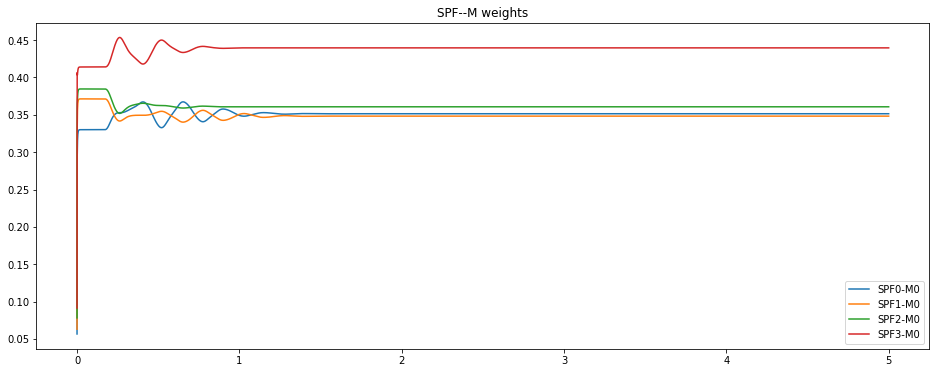

In [5]:
# SPF
fs = (16,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF0', 'SPF1', 'SPF2', 'SPF3'])
plt.title('SPF')
print(SPF_data[:,-1])

# SPF inputs derivatives
#"""
diff_fig = plt.figure(figsize=fs)
spf_diff_track_data = np.array(data[spf_diff_track])
plt.plot(times, spf_diff_track_data.transpose())
plt.legend(['SPF0 diff', 'SPF1 diff', 'SPF2 diff', 'SPF3 diff'])
plt.title('SPF derivatives')
#"""
# M0
M0_fig = plt.figure(figsize=fs)
M0_data = np.array(data[M[0]])
plt.plot(times, M0_data.transpose())
plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('M0')
print(M0_data[-1])

# M1
M1_fig = plt.figure(figsize=fs)
M1_data = np.array(data[M[1]])
plt.plot(times, M1_data.transpose())
plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('M1')
print(M1_data[-1])

# SPF--M weights
W_fig = plt.figure(figsize=fs)
w_track_data = np.array(data[SPF_M0_track])
plt.plot(times, w_track_data.transpose())
plt.legend(['SPF0-M0', 'SPF1-M0', 'SPF2-M0', 'SPF3-M0'])
plt.title('SPF--M weights')

plt.show()

angle: -102.935066, vel: -41.006550


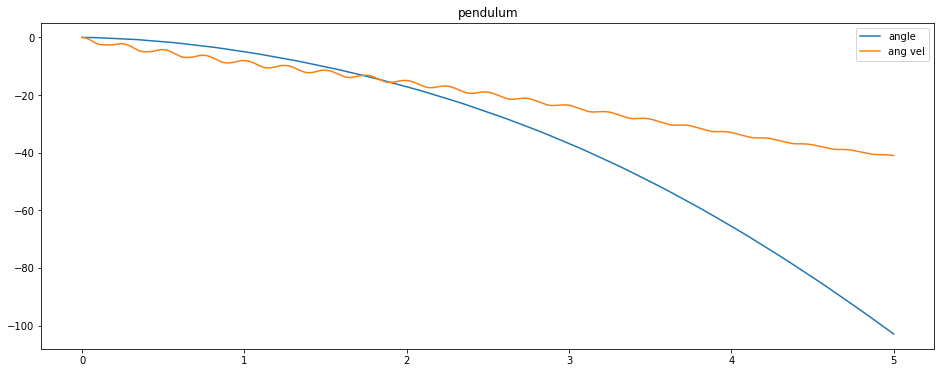

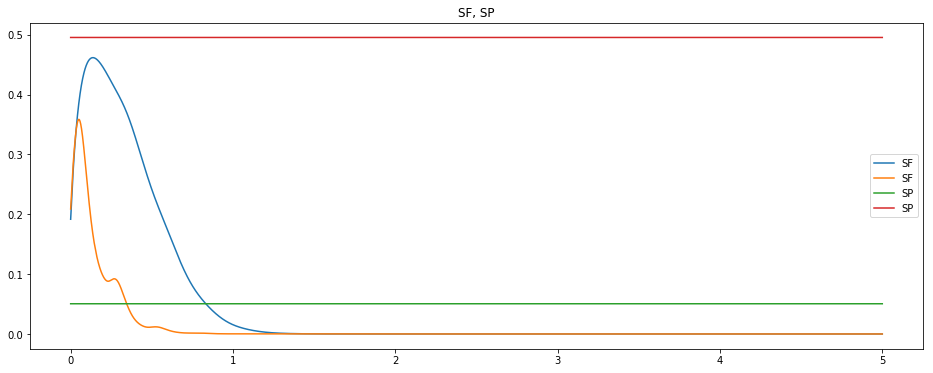

SF = [0.000000, 0.000000]
SP = [0.050485, 0.495299]


In [6]:
# P
P_fig = plt.figure(figsize=(16,6))
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
plt.plot(times, P_data[:,1], label='ang vel')
plt.legend()
plt.title('pendulum')
print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# SF, SP
SF_fig = plt.figure(figsize=(16,6))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP')
plt.legend()
plt.title('SF, SP')
plt.show()
print('SF = [%f, %f]' % (SF_data[0,-1],SF_data[1,-1]))
print('SP = [%f, %f]' % (SP_data[0,-1], SP_data[1,-1]))

In [37]:
SF_data[:,-1]

array([9.29100088e-128, 1.43622109e-026])

In [31]:
len(times)

5000